# Prediction of monthly milk production

Task: Apply the ARIMA building algorithm to create a model and predict monthly production of milk by production values of previous months.

In [1]:
import warnings
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib inline

In [3]:
def print_dickey_fuller(col):
    print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(col)[1])

In [4]:
def plot_series(col, col_name):
    plt.figure(figsize=(15,7))
    col.plot()
    plt.ylabel(col_name)
    plt.show()

## 1. Series visual analysis

In [5]:
df = pd.read_csv(
    'monthly-milk-production.csv', 
    sep=',', 
    index_col=['month'], 
    parse_dates=['month'], 
    dayfirst=True
)
df.head()

,milk
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


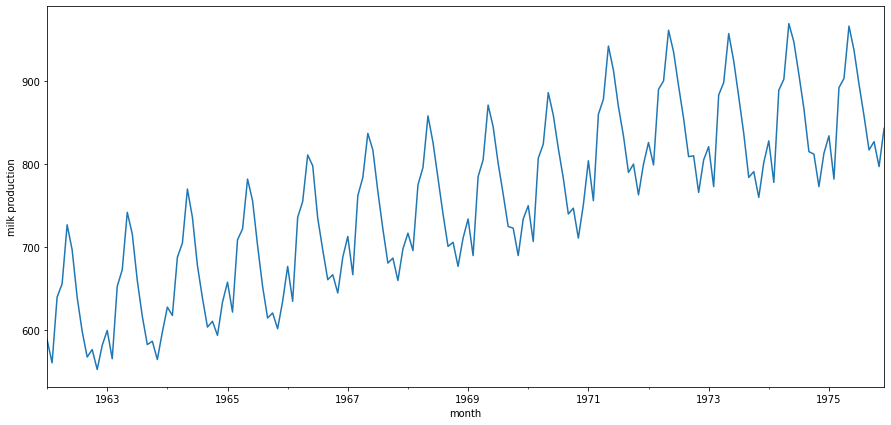

In [6]:
plot_series(df.milk, 'milk production')

In [7]:
print_dickey_fuller(df.milk)

Dickey-Fuller test: p=0.627427


According to Dickey-Fuller test, our time series is not stationary. Let's apply some transformation to the series.
Looking at the series plot, we can notice small differences in the variance, a  trend and seasonality.

## 2. Dispersion stabilization

In [8]:
df['milk_box'], lmbda = stats.boxcox(df['milk'])
print("Optimal parameter of the Box-Cox transformation: %f" % lmbda)

Optimal parameter of the Box-Cox transformation: 0.838297


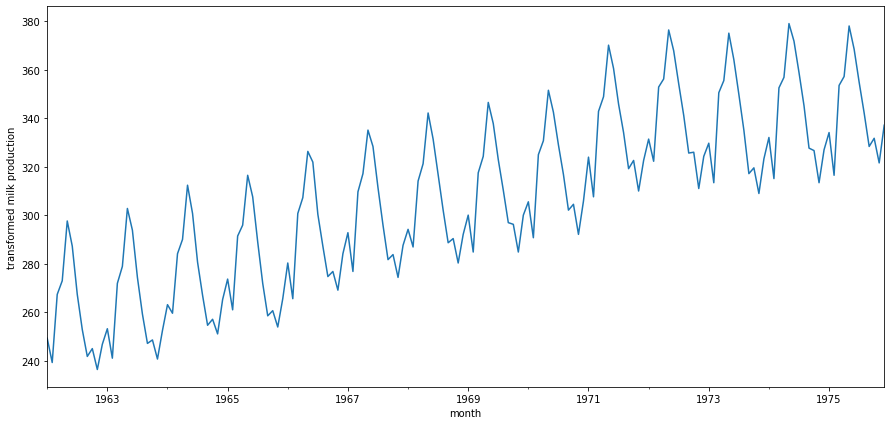

In [9]:
plot_series(df.milk_box, 'transformed milk production')

In [10]:
print_dickey_fuller(df.milk_box)

Dickey-Fuller test: p=0.596911


Dickey-Fuller test showes us a slightly better result, but there are still a trend and seasonality in the series.

## 3. Selection of order of differentiation

### 3.1 Seasonal differentiation


In [11]:
df['milk_box_diff'] = df.milk_box - df.milk_box.shift(12)

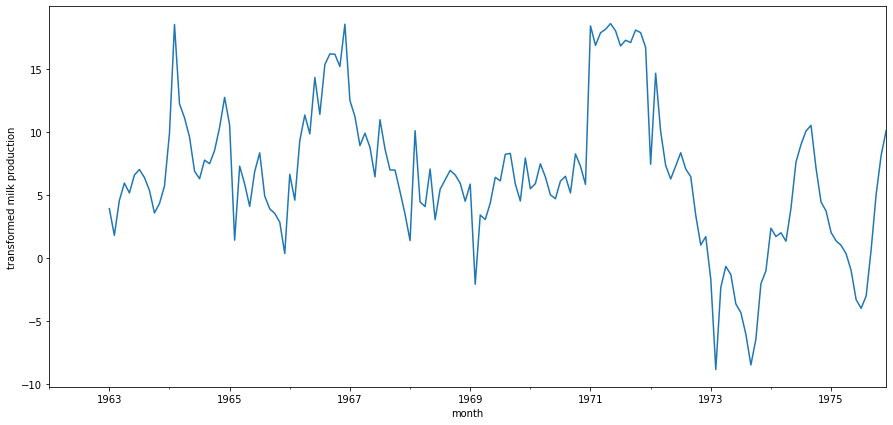

In [12]:
plot_series(df.milk_box_diff, 'transformed milk production')

In [13]:
print_dickey_fuller(df.milk_box_diff[12:])

Dickey-Fuller test: p=0.153502


### 3.2 Ordinary differentiation

In [14]:
df['milk_box_diff2'] = df.milk_box_diff - df.milk_box_diff.shift(1)

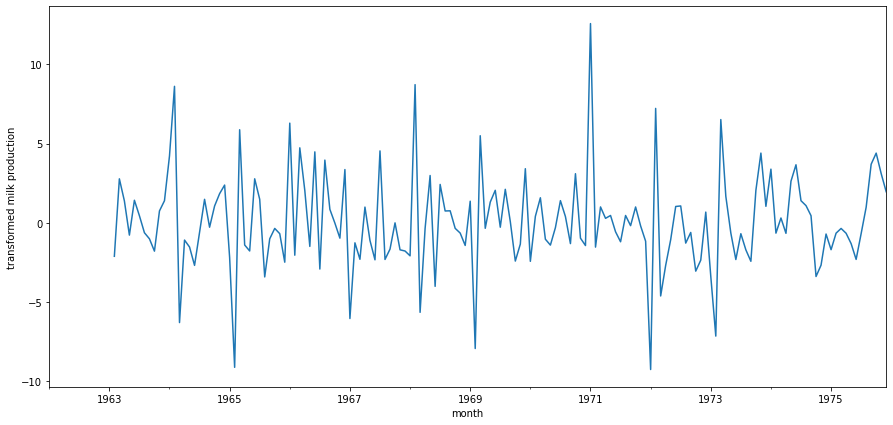

In [15]:
plot_series(df.milk_box_diff2, 'transformed milk production')

In [16]:
print_dickey_fuller(df.milk_box_diff2[13:])

Dickey-Fuller test: p=0.000025


These both differentiation transformations gave us almost stationary series. Nevertheless, we can try to differentiate the series a few more times (but remember that with an increase of the differentiations' number, the forecast variance may increase).

In [17]:
df['milk_box_diff3'] = df.milk_box_diff2 - df.milk_box_diff2.shift(1)
print_dickey_fuller(df.milk_box_diff3[14:])

Dickey-Fuller test: p=0.000141


In [18]:
df['milk_box_diff4'] = df.milk_box_diff3 - df.milk_box_diff3.shift(1)
print_dickey_fuller(df.milk_box_diff4[15:])

Dickey-Fuller test: p=0.000000


## 4. Selection of initial values for p, q, P, Q

Let's take a look at the ACF and PACF of the final series:

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


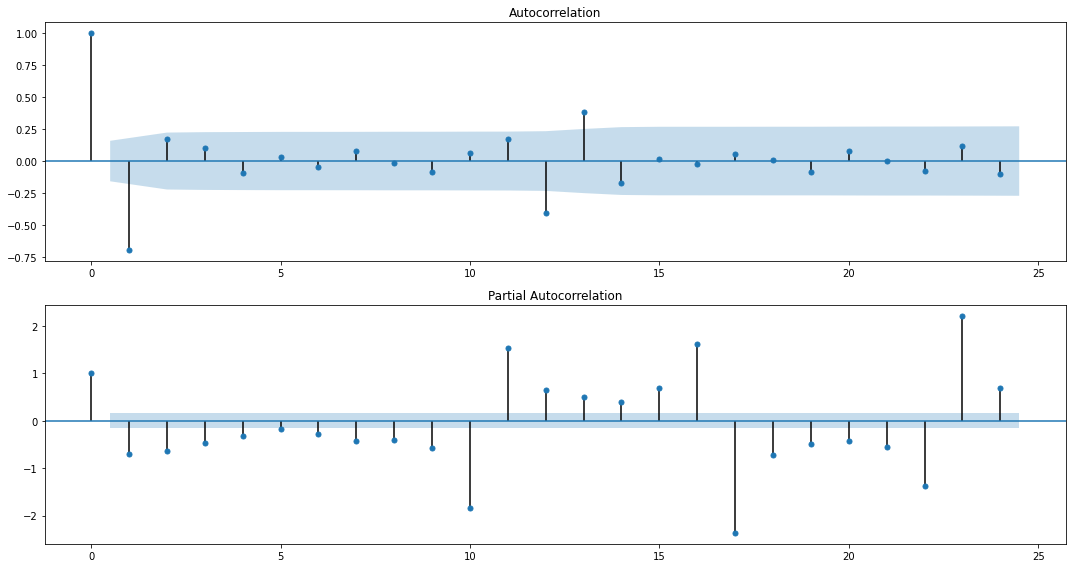

In [19]:
plt.figure(figsize=(15, 8))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.milk_box_diff4[15:].values.squeeze(), lags=24, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.milk_box_diff4[15:].values.squeeze(), lags=24, ax=ax)
plt.tight_layout()

plt.show()

Thus we choose Q=0, q=1, P=1, p=11.

## 5. Models' comparison 

In [20]:
Qs = range(1)
qs = range(2)
Ps = range(2)
ps = range(12)
d = 3
D = 1

In [21]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [22]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df.milk_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=True)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 2min 7s, sys: 1min 34s, total: 3min 42s
Wall time: 1min 53s


In [23]:
result_table = pd.DataFrame(results, columns=['parameters', 'aic'])
result_table.sort_values(by='aic', ascending=True).head()

,parameters,aic
39,"(9, 1, 1, 0)",776.902128
47,"(11, 1, 1, 0)",778.489680
31,"(7, 1, 1, 0)",778.551526
43,"(10, 1, 1, 0)",778.741521
35,"(8, 1, 1, 0)",778.865681


Finally, best model:

In [24]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           milk_box   No. Observations:                  168
Model:             SARIMAX(9, 3, 1)x(1, 1, 0, 12)   Log Likelihood                -376.451
Date:                            Sun, 12 Sep 2021   AIC                            776.902
Time:                                    21:12:48   BIC                            813.267
Sample:                                01-01-1962   HQIC                           791.674
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1577      0.082    -14.162      0.000      -1.318      -0.997
ar.L2         -1.0418      0.143   

## 6. Analysis of model residuals

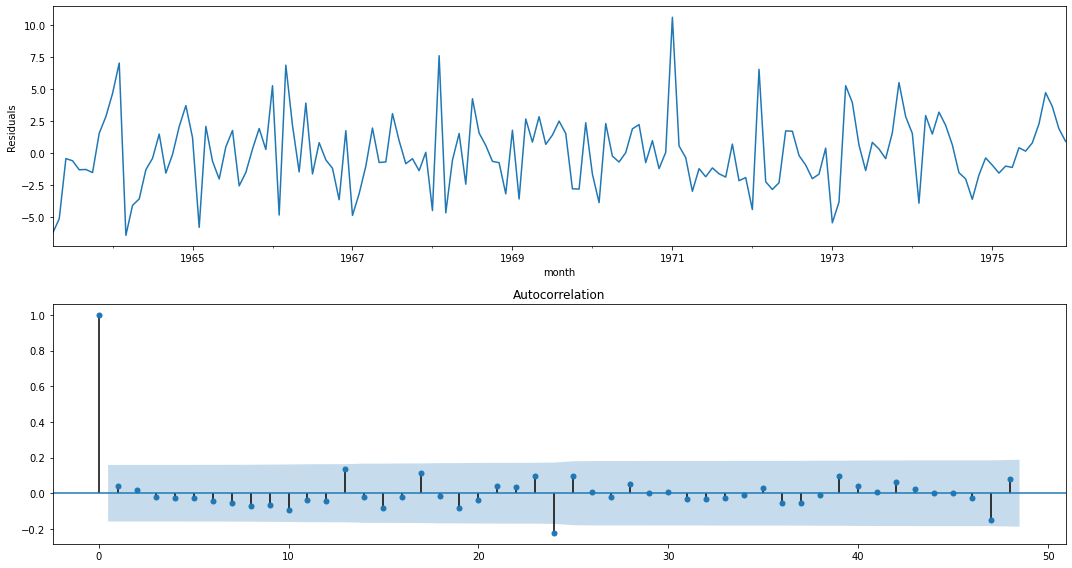

In [25]:
plt.figure(figsize=(15,8))

ax = plt.subplot(211)
best_model.resid[15:].plot(ax=ax)
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[15:].values.squeeze(), lags=48, ax=ax)

plt.tight_layout()
plt.show()

In [26]:
print_dickey_fuller(best_model.resid[15:])

Dickey-Fuller test: p=0.000000


Residuals are unbiased, stationary and there's no autocorrelation.

In [28]:
def invboxcox(y, lmd):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmd*y + 1) / lmd))

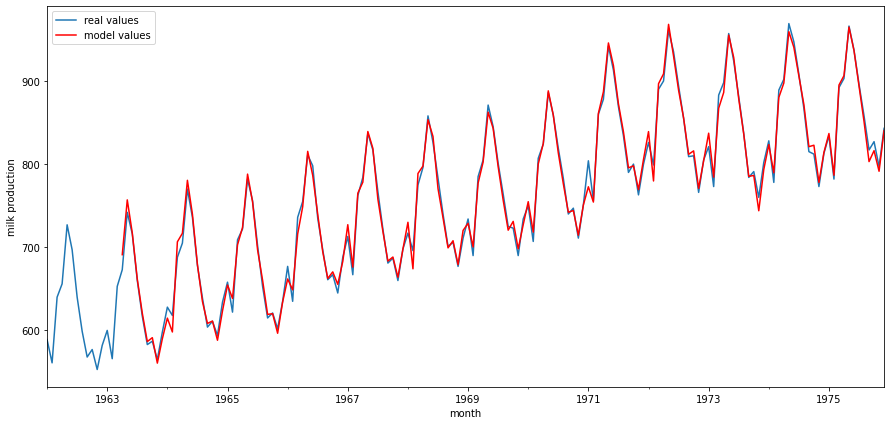

In [29]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize=(15,7))
df.milk.plot(label='real values')
df.model[15:].plot(color='r', label='model values')
plt.ylabel('milk production')
plt.legend()
plt.show()

## 7. Predicting using final model

In [30]:
start, end = "1975-12-01", "1978-03-01"

In [31]:
df2 = df[['milk']]
date_range = pd.date_range(start=start, end=end, freq='MS')
future = pd.DataFrame(index=date_range, columns=df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=start, end=end), lmbda)

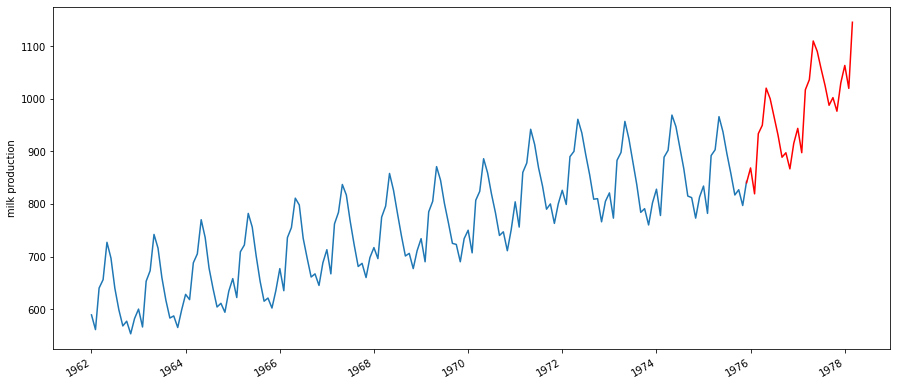

In [32]:
plt.figure(figsize=(15,7))
df2['milk'].plot()
df2['forecast'].plot(color='r')
plt.ylabel('milk production')
plt.show()